# Load Data

In [4]:
import seaborn as sns
import re

In [5]:
import pandas as pd

df = pd.read_csv("../data/album_age_ratings.csv")
print ("Columns of df: ",  list(enumerate(df.columns)), "\n")

print ("Shape of df: ", df.shape, "\n")

print ("Number of albums having description: ", df['Description'].notnull().sum(), "\n")

df.head(3)

Columns of df:  [(0, 'Title'), (1, 'Age'), (2, 'Age Group'), (3, 'Artist'), (4, 'Year'), (5, 'Description')] 

Shape of df:  (2206, 6) 

Number of albums having description:  2206 



,Title,Age,Age Group,Artist,Year,Description
0,Sesame Street: Halloween Collection,2,Toodler,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th..."
1,A Child's Celebration of Rock 'n' Roll,2,Toodler,Various Artists,1996,Songs to get toddlers and teens energized.
2,Wake up Jeff,2,Toodler,The Wiggles,2000,Songs and scenes certain to keep kids attenti...


# Text Processing

In [6]:
import spacy
nlp = spacy.load("en", disable=['parser','ner','tagger', 'textcat'])

In [7]:
import re

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS

stopwords = set(my_lemmatizer(' '.join(list(stopwords))))

# Bag-of-Words Model + K-Mean clustering

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
max_features = 1000

cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=1, max_df=0.9, max_features=max_features)
counts = cv.fit_transform(df['Description'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [9]:
import random   
random.sample(list(cv.get_feature_names_out()), 10)    #random select 10 words from CountVectorizer

['tedious',
 'fun',
 'sexist',
 'version',
 'gentle',
 'mar',
 'clever',
 'intense',
 'casual',
 'duo']

In [10]:
from sklearn.cluster import KMeans
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)
kmc_5.cluster_centers_
import numpy as np

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
love family sex message album cd rock fun music song 

Cluster 1: 
idol country rock squeaky pop tune love song track clean 

Cluster 2: 
parent tune old young okay music fun friendly song kid 

Cluster 3: 
country fun star dance electro song punk tweens rock pop 

Cluster 4: 
well mature song explicit tweens okay old rap tune teen 



In [11]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()
word_df.sample(3)

,album,cd,clean,country,dance,electro,explicit,family,friendly,fun,...,song,squeaky,star,teen,track,tune,tweens,well,young,Cluster
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
758,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


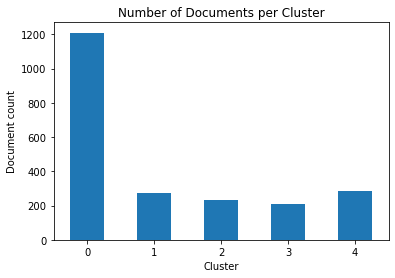

In [12]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

# Latent Dirichlet allocation (LDA)

In [13]:
import gensim

import re
def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_ not in stop_words])
    return result

processed_text = process_words(df['Description'], stop_words=stopwords.union(['-PRON-','song','album','cd','track']))

In [14]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))
corpus = [dictionary.doc2bow(t) for t in processed_text]
num_topics = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

Number of unique tokens: 2528


In [15]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=5))

[(0,
  '0.024*"kid" + 0.023*"teen" + 0.023*"clean" + 0.021*"pop" + 0.017*"mature"'),
 (1,
  '0.030*"tune" + 0.025*"rap" + 0.024*"clean" + 0.022*"message" + 0.018*"sex"'),
 (2,
  '0.034*"talk" + 0.034*"sound" + 0.032*"love" + 0.029*"kid" + 0.029*"lyric"'),
 (3,
  '0.056*"fun" + 0.034*"rock" + 0.033*"pop" + 0.027*"country" + '
  '0.026*"message"'),
 (4, '0.075*"edgy" + 0.073*"hip" + 0.066*"hop" + 0.042*"graphic" + 0.041*"ok"')]


In [16]:
lda_model.get_document_topics(corpus[0])

[(0, 0.06699819),
 (1, 0.5026351),
 (2, 0.03516461),
 (3, 0.37131524),
 (4, 0.023886794)]

In [17]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [18]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

main_topic_df.sample(10)

,Dominant_topic,Percent,Processed_text,Keywords
396,0,0.887,"[terrific, music, kid, point, view]",clean explicit kid mature party pop rap rock t...
829,0,0.887,"[pussycat, clean, act, pop, love]",clean explicit kid mature party pop rap rock t...
1878,1,0.501,"[tragic, intense, film, deliver, passion]",cd clean message pop rap sex star strong tune ...
306,0,0.512,"[music, memorable, lyric]",clean explicit kid mature party pop rap rock t...
2099,1,0.863,"[confusing, mix, shock, vulgar, rap, radio, fr...",cd clean message pop rap sex star strong tune ...
1793,1,0.842,"[deep, stuff, hide, message, worry]",cd clean message pop rap sex star strong tune ...
828,0,0.866,"[idol, runner, warn, player]",clean explicit kid mature party pop rap rock t...
528,1,0.901,"[hannah, reign, end, clean, tween, friendly, t...",cd clean message pop rap sex star strong tune ...
1053,0,0.900,"[another, yawn, manufacture, safe, pop, star]",clean explicit kid mature party pop rap rock t...
762,4,0.473,"[tales, heartbreak, fill, disney, star, sad, w...",cd edgy graphic hip hop offer ok old pop teen


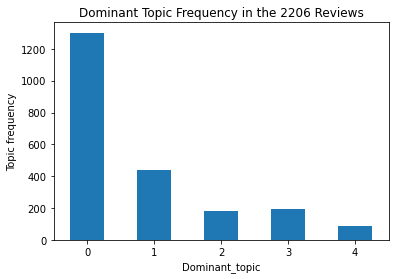

In [19]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} Reviews'.format(len(df)),
        ylabel='Topic frequency'); 

In [20]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives

,Dominant_topic,Percent,Processed_text,Keywords
406,0,0.933,"[pint, size, music, festival, hit, bring, pare...",clean explicit kid mature party pop rap rock t...
938,1,0.911,"[self, esteem, reign, supreme, clean, uplift, ...",cd clean message pop rap sex star strong tune ...
328,2,0.906,"[tribute, 60s, kid, mix, folk, pop, peace, love]",classic kid love lyric music pop rock sex soun...
566,3,0.904,"[viral, smash, animal, noise, fun, goofy, pop,...",country family fun hit love message movie musi...
264,4,0.888,"[tv, tune, ok, whet, appetite, tv, time]",cd edgy graphic hip hop offer ok old pop teen


In [21]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive



def f(idx):
    print('Document: {}  Dominant topic: {}\n'.format(representatives.index[idx], 
                                       representatives.loc[representatives.index[idx]]['Dominant_topic']))
    print(df['Description'][representatives.index[idx]])

    
interactive(f, idx = widgets.Dropdown(options=[0,1,2,3,4], value=0, description='topic id'))

interactive(children=(Dropdown(description='topic id', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…